#### importar librerias

In [96]:
# pip install notebook jupyter ipykernel
import os
import openpyxl
import csv
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('ggplot')
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample
from scipy.stats import normaltest

#### funciones

In [97]:
def importar_data(ruta, archivo, ext):
    """
    Importa datos desde un archivo .csv o .xlsx y los almacena en un DataFrame.
    """
    try:
        ruta_completa = os.path.join(ruta, archivo + ext)

        if ext == '.csv':
            return pd.read_csv(ruta_completa)
        elif ext == '.xlsx':
            return pd.read_excel(ruta_completa)
        else:
            raise ValueError("Extensión no válida. Usa .csv o .xlsx")
    
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {ruta_completa}")
        return None
    except Exception as e:
        print(f"Error al importar el archivo: {e}")
        return None

def datos_NA(df):
    """
    Función para identificar datos NA
    
    identifica el nombre de la columna, tipo de dato, número de valores distintos y valores NA
    además, verifica si df es un DataFrame antes de procesarlo.
    """
    if not isinstance(df, pd.DataFrame):
        print(f"Se esperaba un DataFrame, pero se recibió {type(df)}")
        return None

    print(f"\nDimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"Total Valores NA: {df.isna().sum().sum()}\n")

    info_df = pd.DataFrame({
        'Columna': df.columns,
        'Tipo de Dato': df.dtypes.values,
        'Valores Únicos': df.nunique().values,
        'Valores NA': df.isna().sum().values
    })

    print(info_df.to_string(index=False)) 

def cambiar_encabezados(df, listaN):
    """
    Función para cambiar los encabezados de un DataFrame
    Cambia el nombre de las columnas de un dataframe por los nombres de una lista.
    """
    df.columns = listaN
    return df

def histograma_plot(df, nomCol, anchoBar):
    """
    Función para pintar un histograma de una columna
    """
    sns.histplot(data=df, x=nomCol, binwidth=anchoBar, kde=True)

def imputacion_NA(df, nomCol, param):
    """
    Función para reemplazar valores NA en un DataFrame

    Reemplaza los valores NA de una columna en un DataFrame por la media o mediana de la misma.
    """
    if param == 'media':
        df[nomCol] = df[nomCol].fillna(df[nomCol].mean())
        return df[nomCol]
    else:
        df[nomCol] = df[nomCol].fillna(df[nomCol].median())
        return df[nomCol]

def revisar_categoricos(df, nomCol):
    """
    Función para revisar valores categóricos 
    """
    return df[nomCol].value_counts()

def imputacion_categoricos(df, nomCol, busqueda, reempl):
    """
    Función para remplazar valores categóricos modificados en una columna
    """
    df[nomCol] = np.where(df[nomCol] == busqueda, reempl, df[nomCol])
    return df[nomCol]

def imputacion_categoricos_NA(df, nomCol):
    """
    Función para reemplazar valores NA en una columna categórica
    """
    df[nomCol] = df[nomCol].fillna(df[nomCol].mode()[0])
    return df[nomCol]

def cambiar_text_num(df, nomCol, tipo):
    """
    Función para cambiar datos de texto (object) a numerico (float64)
    """
    df[nomCol] = df[nomCol].astype(tipo)
    return df[nomCol]

def cambiar_text_binario(df, nomCol, busqueda, camuno, camdos):
    """
    Función para cambiar datos texto a binarios
    """
    df[nomCol] = np.where(df[nomCol] == busqueda, camuno, camdos)
    return df[nomCol]

def label_encoder(df,nomCol):
    """
    Convierte una variable categórica en valores numéricos mediante Label Encoding.

    Asigna un número único a cada categoría dentro de la columna especificada.
    """
    label_e = LabelEncoder()
    df[nomCol] = label_e.fit_transform(df[nomCol])
    return df[nomCol]

def convertir_dummies(df, nomCol):
    """
    Convierte una variable categórica en variables dummies mediante One-Hot Encoding.

    Crea una nueva columna para cada categoría de la variable especificada, 
    asignando 1 si la fila pertenece a esa categoría y 0 si no.
    """
    dummies = pd.get_dummies(df[nomCol], dtype=int)  # dtype=int convierte True/False a 0/1
    data = pd.concat([df, dummies], axis=1)
    data.drop(columns=[nomCol], inplace=True)
    return data

# Función para el test de Shapiro - wilk - resistente al ruido en los datos

def test_shapiro_wilk(df):
    """
    Evalúa si las variables numéricas del DataFrame siguen una distribución normal con base en el valor p.

    Criterios de decisión:
    - p < 0.05 → La variable NO sigue una distribución normal.
    - p >= 0.05 → La variable sigue una distribución normal.

    Notas:
    - La prueba de Shapiro-Wilk es sensible a tamaños de muestra grandes (>5000).
    - Se asume que todas las columnas del DataFrame contienen datos numéricos.
    """
    valoresP = []
    concepto = []
    variable = []
    for column in df:
        k2, p_value = stats.shapiro(df[column].values)
        valoresP.append(p_value)
        variable.append(column)
        if (p_value < 0.05):
            concepto.append('No es una variable Normal')
        else:
            concepto.append('Es una variable Normal')
    dfShapiro = pd.DataFrame(
        {'Variable': variable, 'Valores P': valoresP, 'Concepto': concepto})
    return dfShapiro

def normalizar_data(df):
    """
    Normaliza los valores numéricos de un DataFrame utilizando Min-Max Scaling.

    Esta función escala todas las columnas del DataFrame a un rango entre 0 y 1 
    utilizando la técnica de Min-Max Scaling.
    """
    valores = df.values  
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(valores)

    pd.DataFrame(np.vstack((scaler.data_min_, scaler.data_max_)),
             index=['Min', 'Max'],
             columns=df.columns)

    normalizados = scaler.transform(valores)
    df_norm = pd.DataFrame(normalizados,
                       index=df.index,
                       columns=df.columns)
    return df_norm

def estandarizar_data(df):
    """
    Estandariza los valores numéricos de un DataFrame utilizando la fórmula Z-Score.

    Transforma los datos para que tengan media 0 y desviación estándar 1 
    mediante la técnica de estandarización Z-Score con `StandardScaler`.
    """
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    df_stan = pd.DataFrame(standardized_data, columns=df.columns)
    return df_stan

## Función para hacer la matriz de correlación de manera Tidy

def tidy_correlacion_matriz(corr_mat):
    '''
    Convierte una matriz de correlación de pandas en un formato tidy.

    Esta función transforma una matriz de correlación en un DataFrame de tres columnas: 
    'variable_1', 'variable_2' y 'r' (coeficiente de correlación), eliminando las 
    correlaciones redundantes (diagonal de la matriz) y agregando una columna con el 
    valor absoluto de la correlación para facilitar el ordenamiento.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    return corr_mat


#### importar data

In [98]:
df = importar_data(r'C:\Users\user\Desktop\ejercicios_MD\1\dataset\\', 'CovidDiagnosis', '.xlsx')
df

,Age,Gender,Temperature,Headache,Fever,Hospital,CovidDiagnosis
0,12.0,Masculino,36°,SI,1.0,Moncaleano,positive
1,35.0,Femenino,38,NO,0.0,Medilaser,negative
2,65.0,NaN,36C,YES,1.0,Carmen Emilia,negative
3,78.0,NaN,39,NOP,1.0,Moncaleano,negative
4,41.0,Masculino,40.,SI,0.0,Medilaser,positive
...,...,...,...,...,...,...,...
94,7.0,Femenino,42,OUI,1.0,Medilaser,positive
95,7.0,Masculino,35,OUI,0.0,Carmen Emilia,positive
96,25.0,Femenino,35.2,YES,NaN,Moncaleano,negative
97,26.0,Femenino,35.6,YES,NaN,Medilaser,negative


In [99]:
# convertir a dataframe
df = pd.DataFrame(df)
# verificar
type(df)

pandas.core.frame.DataFrame

#### verificar datos NA 

In [100]:
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 49

       Columna Tipo de Dato  Valores Únicos  Valores NA
           Age      float64              46           3
        Gender       object               6           3
   Temperature       object              30           1
      Headache       object               6          35
         Fever      float64               2           7
      Hospital       object               3           0
CovidDiagnosis       object               2           0


<Axes: >

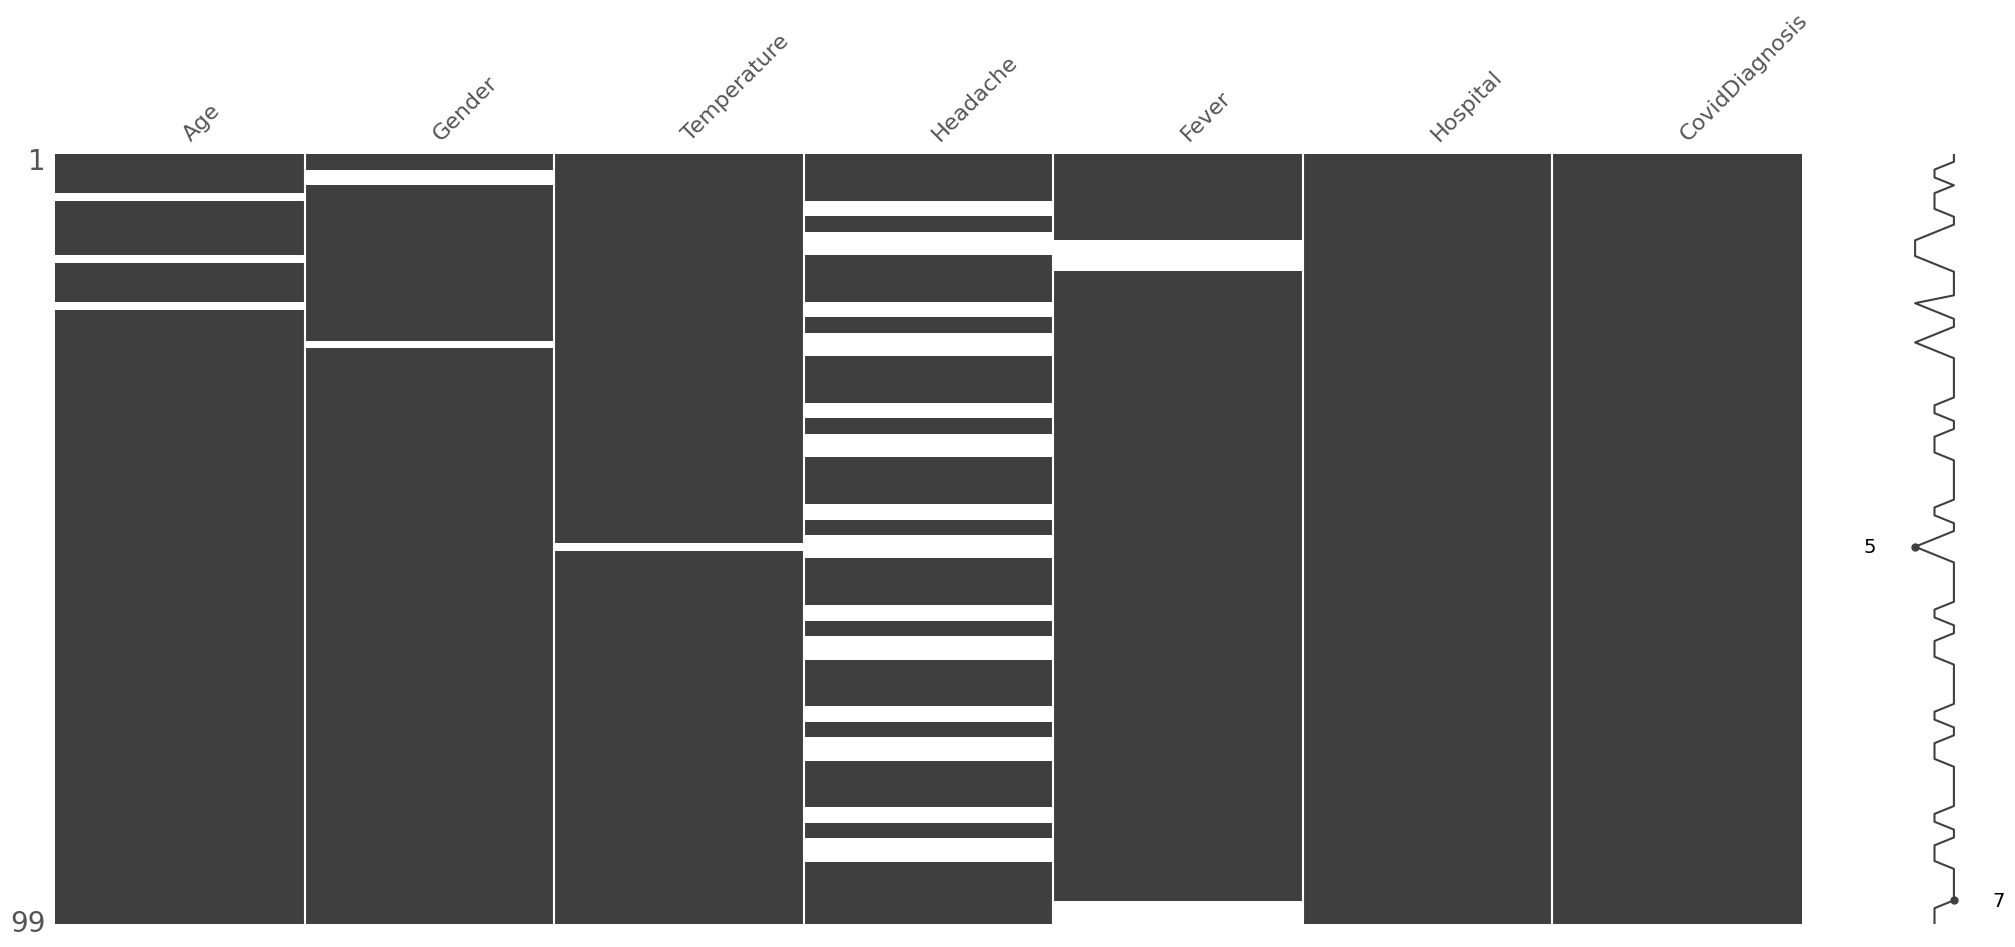

In [101]:
# visualizar datos faltantes
msno.matrix(df)

#### limpieza de datos NA

In [102]:
# cambiar encabezados
cambiar_encabezados(df, ['Edad','Genero','Temperatura','DolorCabeza','Fiebre','Hospital','DiagnosticoCovid'])
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 49

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           3
          Genero       object               6           3
     Temperatura       object              30           1
     DolorCabeza       object               6          35
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


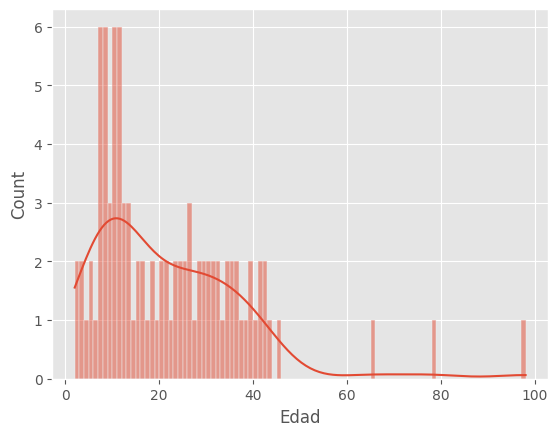

In [103]:
# revisar columna edad
histograma_plot(df, 'Edad', 1)

In [104]:
# como se observa no hay campana de gauss, entonces se remplazan datos NA con la mediana
imputacion_NA(df, 'Edad', 'mediana')
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 46

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               6           3
     Temperatura       object              30           1
     DolorCabeza       object               6          35
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


In [105]:
# revisar columna genero
revisar_categoricos(df, 'Genero')

Genero
Femenino          60
Masculino         23
Masculinoooo       6
femenino           5
Masculino…..//     1
masculino          1
Name: count, dtype: int64

In [106]:
# limpieza de datos categoricos modificados
imputacion_categoricos(df, 'Genero', 'Masculinoooo', 'Masculino')
imputacion_categoricos(df, 'Genero', 'Masculino…..//', 'Masculino')
imputacion_categoricos(df, 'Genero', 'masculino', 'Masculino')
imputacion_categoricos(df, 'Genero', 'femenino', 'Femenino')
# verificar
revisar_categoricos(df, 'Genero')

Genero
Femenino     65
Masculino    31
Name: count, dtype: int64

In [107]:
# revisar datos NA en columna genero
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 46

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               2           3
     Temperatura       object              30           1
     DolorCabeza       object               6          35
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


In [108]:
# se remplazan los datos NA con la moda
imputacion_categoricos_NA(df, 'Genero')
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 43

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               2           0
     Temperatura       object              30           1
     DolorCabeza       object               6          35
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


In [109]:
revisar_categoricos(df, 'Genero')

Genero
Femenino     68
Masculino    31
Name: count, dtype: int64

In [110]:
# revisar columna temperatura
df['Temperatura']

0      36°
1       38
2      36C
3       39
4      40.
      ... 
94      42
95      35
96    35.2
97    35.6
98    36.9
Name: Temperatura, Length: 99, dtype: object

In [111]:
# datos incosisntentes en la columna temperatura
imputacion_categoricos(df, 'Temperatura', '36C', 36)
imputacion_categoricos(df, 'Temperatura', '36°', 36)
# verificar
df['Temperatura']


0       36
1       38
2       36
3       39
4      40.
      ... 
94      42
95      35
96    35.2
97    35.6
98    36.9
Name: Temperatura, Length: 99, dtype: object

In [112]:
# cambio de tipo de dato de object (texto) a float64 (número)
cambiar_text_num(df, 'Temperatura', 'float64')

0     36.0
1     38.0
2     36.0
3     39.0
4     40.0
      ... 
94    42.0
95    35.0
96    35.2
97    35.6
98    36.9
Name: Temperatura, Length: 99, dtype: float64

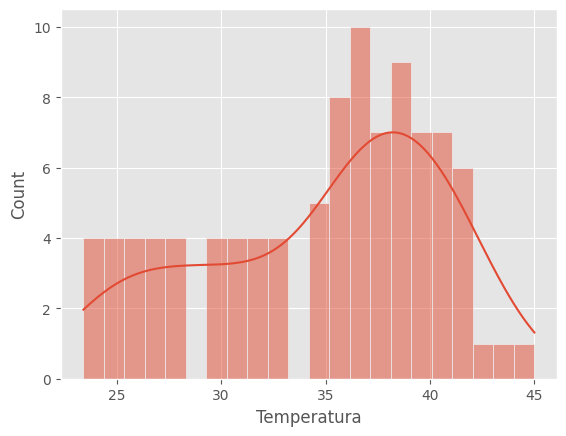

In [113]:
# revisar datos NA columna temperatura
histograma_plot(df, 'Temperatura', 1)

In [114]:
# no hay campana de gauss, entonces se remplazan datos NA con la mediana
imputacion_NA(df, 'Temperatura', 'mediana')
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 42

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               2           0
     Temperatura      float64              28           0
     DolorCabeza       object               6          35
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


In [115]:
# revisar columna dolor de cabeza
revisar_categoricos(df, 'DolorCabeza')

DolorCabeza
SI     14
NO     14
NOP    14
YES    12
SI      7
OUI     3
Name: count, dtype: int64

In [116]:
# limpieza de datos categoricos modificados
imputacion_categoricos(df, 'DolorCabeza', 'YES', 'SI')
imputacion_categoricos(df, 'DolorCabeza', 'SI ', 'SI')
imputacion_categoricos(df, 'DolorCabeza', 'OUI', 'SI')
imputacion_categoricos(df, 'DolorCabeza', 'NOP', 'NO')
# verificar
revisar_categoricos(df, 'DolorCabeza')

DolorCabeza
SI    36
NO    28
Name: count, dtype: int64

In [117]:
# se remplazan los datos NA con la moda
imputacion_categoricos_NA(df, 'DolorCabeza')
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 7

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               2           0
     Temperatura      float64              28           0
     DolorCabeza       object               2           0
          Fiebre      float64               2           7
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


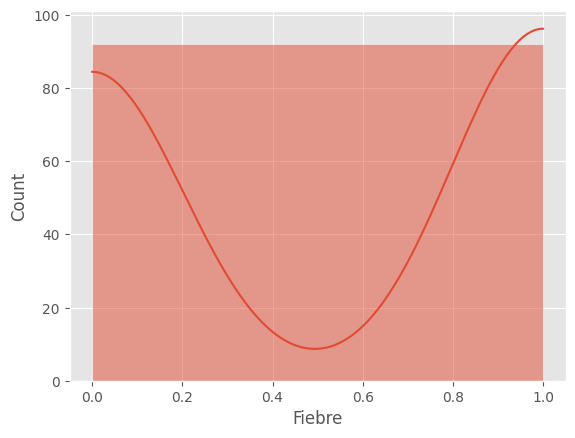

In [118]:
# revisar columna fiebre
histograma_plot(df, 'Fiebre', 1)

In [119]:
# no hay campana de gauss, entonces se remplazan datos NA con la mediana
imputacion_NA(df, 'Fiebre', 'mediana')
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 0

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero       object               2           0
     Temperatura      float64              28           0
     DolorCabeza       object               2           0
          Fiebre      float64               2           0
        Hospital       object               3           0
DiagnosticoCovid       object               2           0


In [120]:
# revisar columna hospital  
revisar_categoricos(df, 'Hospital')

Hospital
Moncaleano       33
Medilaser        33
Carmen Emilia    33
Name: count, dtype: int64

In [121]:
# revisar columna diagnostico covid
revisar_categoricos(df, 'DiagnosticoCovid')

DiagnosticoCovid
negative    60
positive    39
Name: count, dtype: int64

In [122]:
# cambiar a 1 y 0 los valores de las columnas genero, dolor de cabeza y diagnostico covid
cambiar_text_binario(df, 'Genero', 'Femenino', 0, 1) # 0: Femenino, 1: Masculino
cambiar_text_binario(df, 'DolorCabeza', 'NO', 0, 1) # 0: NO, 1: SI
cambiar_text_binario(df, 'DiagnosticoCovid', 'negative', 0, 1) # 0: negative, 1: positive
# verificar
datos_NA(df)


Dimensiones: 99 filas, 7 columnas
Total Valores NA: 0

         Columna Tipo de Dato  Valores Únicos  Valores NA
            Edad      float64              46           0
          Genero        int64               2           0
     Temperatura      float64              28           0
     DolorCabeza        int64               2           0
          Fiebre      float64               2           0
        Hospital       object               3           0
DiagnosticoCovid        int64               2           0


In [123]:
# one hot encoder para la columna hospital
df_final = convertir_dummies(df, 'Hospital') 
# verificar
df_final.head()

,Edad,Genero,Temperatura,DolorCabeza,Fiebre,DiagnosticoCovid,Carmen Emilia,Medilaser,Moncaleano
0,12.0,1,36.0,1,1.0,1,0,0,1
1,35.0,0,38.0,0,0.0,0,0,1,0
2,65.0,0,36.0,1,1.0,0,1,0,0
3,78.0,0,39.0,0,1.0,0,0,0,1
4,41.0,1,40.0,1,0.0,1,0,1,0


In [124]:
# resumen de medidas de tendencia central y dispersión
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Edad,99.0,21.555556,15.882362,2.00,10.00,18.00,30.5,98.0
Genero,99.0,0.313131,0.466127,0.00,0.00,0.00,1.0,1.0
Temperatura,99.0,34.855051,5.718094,23.41,30.67,36.35,39.0,45.0
DolorCabeza,99.0,0.717172,0.452666,0.00,0.00,1.00,1.0,1.0
Fiebre,99.0,0.565657,0.498193,0.00,0.00,1.00,1.0,1.0
DiagnosticoCovid,99.0,0.393939,0.491108,0.00,0.00,0.00,1.0,1.0
Carmen Emilia,99.0,0.333333,0.473804,0.00,0.00,0.00,1.0,1.0
Medilaser,99.0,0.333333,0.473804,0.00,0.00,0.00,1.0,1.0
Moncaleano,99.0,0.333333,0.473804,0.00,0.00,0.00,1.0,1.0


In [125]:
# particionar datos
diagnostico = df_final.loc[3:50, ["Edad", "Genero", "Temperatura", "DolorCabeza", "Carmen Emilia", "Medilaser", "Moncaleano"]]
diagnostico.head()


,Edad,Genero,Temperatura,DolorCabeza,Carmen Emilia,Medilaser,Moncaleano
3,78.0,0,39.0,0,0,0,1
4,41.0,1,40.0,1,0,1,0
5,18.0,0,41.0,0,1,0,0
6,98.0,0,38.5,1,0,0,1
7,12.0,0,38.9,1,0,1,0


####  balancear la data

Undersampling = se reduce el número de muestras de la clase mayoritaria para igualarlo al de la clase minoritaria.
 Oversampling = se aumentan las muestras de la clase minoritaria para igualarlas a la clase mayoritaria.

#### oversampling

In [126]:
# verificar el número de registros por categoría en la variable objetivo (predictora o clasificadora)  
df_final['DiagnosticoCovid'].value_counts()

# separar las clases en dos grupos  
df_mayor = df_final[df_final.DiagnosticoCovid == 0]  # clase mayoritaria (Diagnóstico negativo)  
df_menor = df_final[df_final.DiagnosticoCovid == 1]  # clase minoritaria (Diagnóstico positivo)  

# aplicar sobremuestreo (oversampling) a la clase minoritaria  
df_minoritaria = resample(df_menor,  
                          replace=True,       # se permite la repetición de muestras (duplicados)  
                          n_samples=60,       # se aumentan las muestras a 60 para equilibrar  
                          random_state=123)   # se fija una semilla para reproducibilidad  

# combinar la clase mayoritaria con la clase minoritaria sobremuestreada  
df_over = pd.concat([df_mayor, df_minoritaria])  

# verificar el balance de clases después del oversampling 
df_over.DiagnosticoCovid.value_counts()

DiagnosticoCovid
0    60
1    60
Name: count, dtype: int64

#### under sampling

In [127]:
# Submuestreo (undersampling) de la clase mayoritaria para equilibrar la cantidad de datos  
df_mayoritaria = resample(df_mayor,  
                          replace=False,      # No se permite la repetición de muestras  
                          n_samples=39,       # Se seleccionan 39 muestras aleatorias  
                          random_state=123)   # Se fija una semilla para reproducibilidad  

# Combinar la clase mayoritaria reducida con la clase minoritaria  
df_under = pd.concat([df_mayoritaria, df_menor])  

# Mostrar el conteo de registros por categoría en la columna DiagnosticoCovid  
df_under.DiagnosticoCovid.value_counts()

DiagnosticoCovid
0    39
1    39
Name: count, dtype: int64

#### normalizacion (cuando la data no es normal)

In [128]:
data_shapiro = test_shapiro_wilk(df_final)
data_shapiro

,Variable,Valores P,Concepto
0,Edad,1.430404e-08,No es una variable Normal
1,Genero,2.537548e-15,No es una variable Normal
2,Temperatura,1.067276e-04,No es una variable Normal
3,DolorCabeza,1.120521e-15,No es una variable Normal
4,Fiebre,1.985306e-14,No es una variable Normal
5,DiagnosticoCovid,1.242345e-14,No es una variable Normal
6,Carmen Emilia,4.091982e-15,No es una variable Normal
7,Medilaser,4.091982e-15,No es una variable Normal
8,Moncaleano,4.091982e-15,No es una variable Normal


<Axes: >

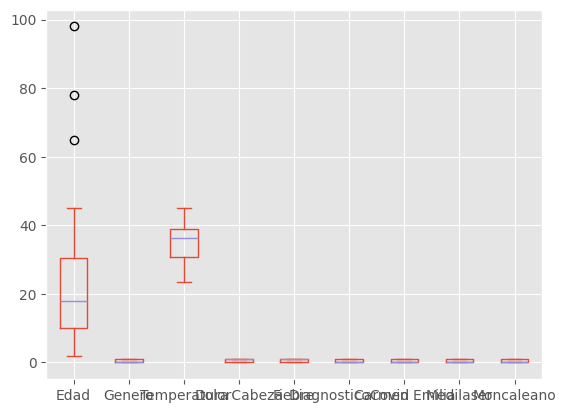

In [129]:
# grafico de caja 
df_final.plot.box() # no hay normalidad en los datos al no tener las mismas medias.

<Axes: >

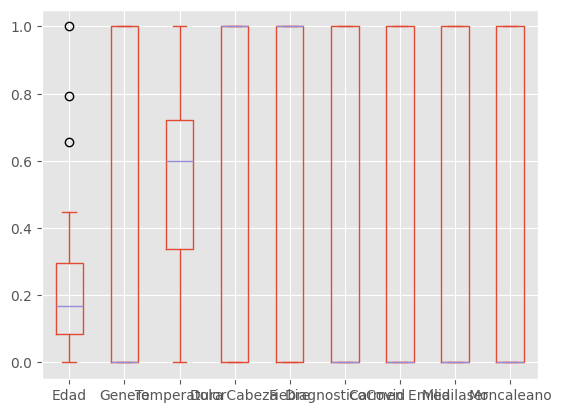

In [130]:
# normalizar data
data_normalizada = normalizar_data(df_final)
# grafico de caja
data_normalizada.plot.box() # nivelacion de los datos

#### estandarización (cuando la data es normal)

<Axes: >

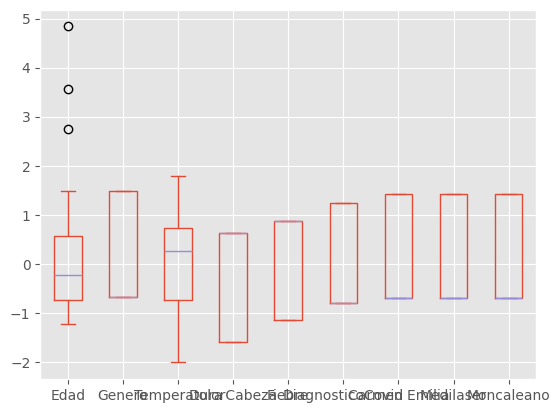

In [131]:
# estandarizacion
data_estandarizada = estandarizar_data(df_final)
# grafico de cajas
data_estandarizada.plot.box() # hay ruido porque la data no es normal.

#### correlaciones

In [132]:
matriz_correlacion= data_estandarizada.corr(method='pearson')
tidy_correlacion_matriz(matriz_correlacion)

,variable_1,variable_2,r,abs_r
61,Carmen Emilia,Medilaser,-5.000000e-01,5.000000e-01
79,Moncaleano,Medilaser,-5.000000e-01,5.000000e-01
71,Medilaser,Moncaleano,-5.000000e-01,5.000000e-01
69,Medilaser,Carmen Emilia,-5.000000e-01,5.000000e-01
78,Moncaleano,Carmen Emilia,-5.000000e-01,5.000000e-01
...,...,...,...,...
53,DiagnosticoCovid,Moncaleano,-8.971499e-18,8.971499e-18
52,DiagnosticoCovid,Medilaser,4.485750e-18,4.485750e-18
68,Medilaser,DiagnosticoCovid,4.485750e-18,4.485750e-18
59,Carmen Emilia,DiagnosticoCovid,2.242875e-18,2.242875e-18


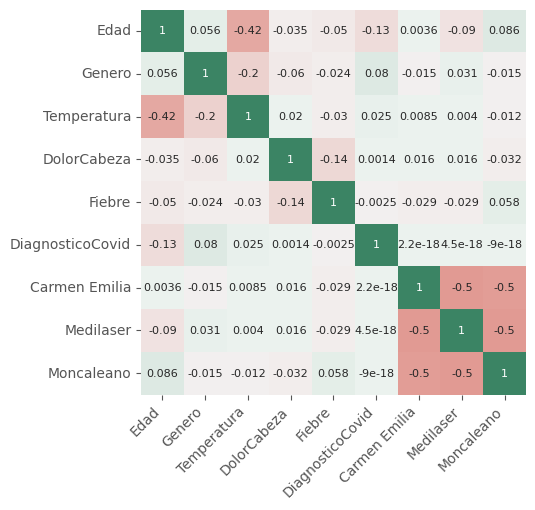

In [133]:
# matriz
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    matriz_correlacion,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(15, 150, n=100),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

#### Cómo leer esta matriz de correlación

Valores entre -1 y 1

Cercanos a 1: Correlación positiva fuerte (cuando una variable aumenta, la otra también).<br>
Cercanos a -1: Correlación negativa fuerte (cuando una variable aumenta, la otra disminuye).<br>
Cercanos a 0: No hay relación entre las variables.<br>

Colores

Verde oscuro: Correlación positiva fuerte.<br>
Rojo oscuro: Correlación negativa fuerte.<br>
Colores claros: Correlaciones débiles o cercanas a 0.<br>

#### Conclusiones

La correlación más fuerte negativa es entre "Edad" y "Temperatura" con -0.42 (cuando una sube, la otra baja).<br>

No hay correlaciones fuertes con "DiagnosticoCovid", lo que sugiere que estas variables por sí solas no son suficientes para predecir el diagnóstico.

In [136]:
# exportar data limpia y normalizada
# data_normalizada.to_csv(r"data_limpia.csv")